In [1]:
!pip install git+https://github.com/christophM/rulefit.git

  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-req-build-cpwhpxfn
  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulefit.git /tmp/pip-req-build-cpwhpxfn
  Resolved https://github.com/christophM/rulefit.git to commit 472b8574b4eb9e565caf1e05ed580998fe2c9a8e
  Preparing metadata (setup.py) ... done


In [57]:
import numpy as np
import pandas as pd

from rulefit import RuleFit, RuleEnsemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt




In [48]:

carbon_data = pd.read_csv("res/carbon_emissions.csv", index_col=0)
carbon_data.head()

,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
Body Type,,,,,,,,,,,,,,,,,,,
overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [49]:
def get_encoded(label, data, encoder):
    le = LabelEncoder()
    le.fit(data[label])
    encoder[label] = le
    return le.transform(data[label])
    

In [52]:
# preprocessing of data:
#carbon_data = carbon_data.dropna(how='any') # drop Nan Values for now in a way i dont care

y = carbon_data.CarbonEmission.values

X = carbon_data.drop("CarbonEmission", axis=1)
#X = carbon_data[["Sex", "Diet"]]
features = X.columns
encoder_dict = {}
for label in X.columns:
    if X[label].dtype != "int" or X[label].dtype != "float":
        X[label] = get_encoded(label, X, encoder_dict)

X = X.to_numpy()
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=42)

X.shape


(10000, 18)

In [53]:
gb = GradientBoostingRegressor(n_estimators=500, max_depth=10, learning_rate=0.01)
rf = RuleFit(tree_generator=gb, max_iter=1000)

rf.fit(X_train, y_train, feature_names=features)

RuleFit(max_iter=1000,
        tree_generator=GradientBoostingRegressor(learning_rate=0.01,
                                                 max_depth=10, max_leaf_nodes=2,
                                                 n_estimators=539,
                                                 random_state=538))

In [61]:
y_predict

array([1110.32203954, 1929.9279894 , 2423.00093339, ..., 3720.93071912,
       3042.9625464 , 2059.51808736])

In [63]:
y_test

array([ 978, 1608, 2236, ..., 3533, 3062, 2064])

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
y_predict = rf.predict(X_test)
print(r2_score(y_test, y_predict.round())) 
print(mean_absolute_error(y_test, y_predict.round()))
print((abs(y_test - y_predict.round())).mean())

0.9260275480944934
218.7135
218.7135


<BarContainer object of 18 artists>

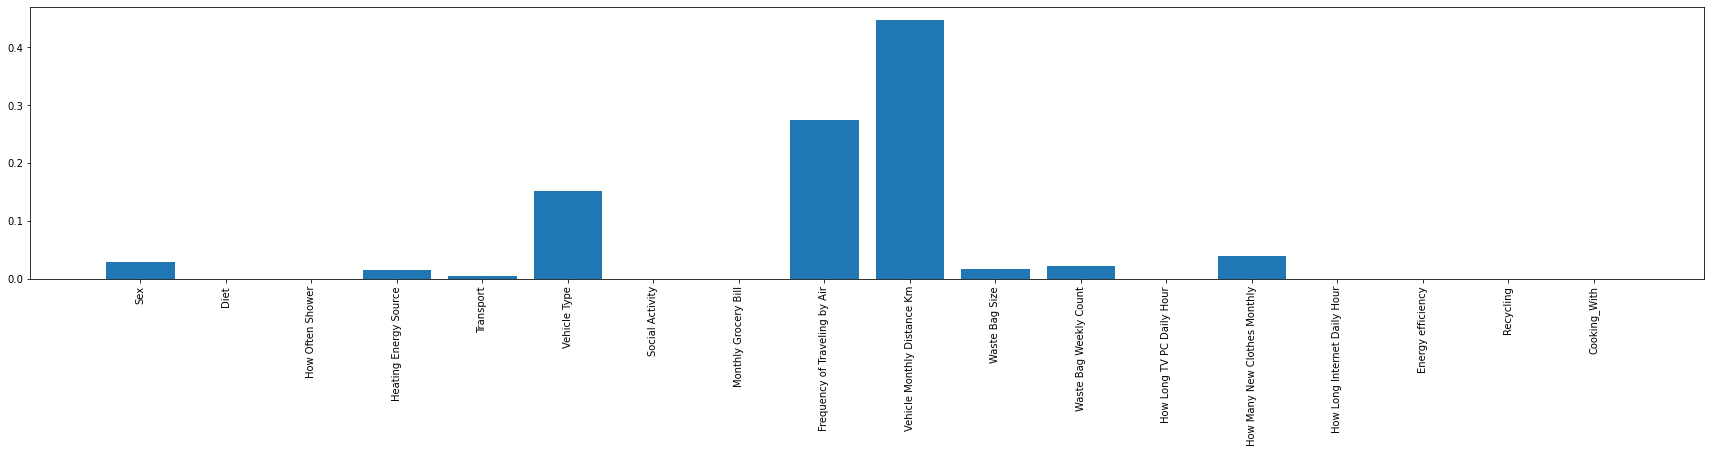

In [41]:

plt.figure(figsize=(30, 5))
plt.xticks(rotation=90)
plt.bar(features, gb.feature_importances_)
#gb.feature_importances_

In [23]:
rf.predict(X)

array([2057.09208708, 1477.99338619, 2399.54629282, ..., 2392.74265088,
       5091.56083915, 1022.08003753])

In [24]:

re = RuleEnsemble(rf.tree_generator, feature_names=features)

rules = re.rules
#rules = rules[rules.coef != 0].sort_values("support", ascending=False)

print(len(rules))

727
